In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import select
from skimage import feature as ft
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import sys
from sklearn import mixture

importpath   = "../../../Dataset/"
testrainpath = ["Testing", "Training"]
namespath    = ["/Abed/", "/Daniel/", "/Jules/", "/Lea/", "/Patrick/"]
rescaledpath = "Rescaled"
croppedpath  = "Cropped"

meta_data = {0: 'Abed', 1: 'Daniel', 2: 'Jules', 3: 'Lea', 4: 'Patrick'}

def get_data(isCropped=True):

    # Test train data
    X_train = []
    Y_train = []

    X_test  = []
    Y_test  = []

    # define both import paths
    testpath = importpath+testrainpath[0]
    trainpath= importpath+testrainpath[1]

    for i, npath in enumerate(namespath):

        if isCropped:
            testfolder = testpath + croppedpath + npath
            trainfolder= trainpath+ croppedpath + npath
        else:
            testfolder = testpath + rescaledpath + npath
            trainfolder= trainpath+ rescaledpath + npath

        for imgname in os.listdir(testfolder):

            img = cv2.imread(testfolder+imgname)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_test.append(img)
            Y_test.append(i)

        for imgname2 in os.listdir(trainfolder):

            img = cv2.imread(trainfolder+imgname2)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_train.append(img)
            Y_train.append(i)

#     # once the data is saved, shuffle it
#     X_train , Y_train = shuffle(X_train, Y_train)
#     X_test  , Y_test  = shuffle(X_test, Y_test)

    return np.asarray(X_train), np.asarray(Y_train), np.asarray(X_test), np.asarray(Y_test), meta_data


In [125]:
def sift(img):

    # copy image
    img_disp = img.copy()
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints = sift.detect(img, None)
    
    p = []
    keypoints3, descriptors = sift.compute(img, keypoints)
    for k in keypoints3:
        p.append(k.pt)

    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    '''
# #     display
      plt.figure(figsize=(10, 10))
      plt.subplot(121), plt.imshow(img)
      plt.title("Input Image"), plt.xticks([]), plt.yticks([])
      plt.subplot(122), plt.imshow(img_disp)
      plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
      plt.show()

#     # num of SIFT keypoints
      print('Num keypoints: ' + str(len(keypoints)))
    '''

    return p


# Get croppped image coordinates in original image (x,y in top left corner)
def get_coordinates(img_rescaled, img_cropped):
    # imgggg_rgb = cv2.imread("../../../Dataset/TrainingRescaled/Abed/scale1_0.jpeg")
    # img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    # template = cv2.imread("../../../Dataset/TrainingCropped/Abed/scale1_0.jpeg", 0)
    img_rescaled = cv2.cvtColor(img_rescaled, cv2.COLOR_BGR2GRAY)
    img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    w, h = img_cropped.shape[::-1]
    res = cv2.matchTemplate(img_rescaled, img_cropped, cv2.TM_SQDIFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    x = top_left[0]
    y = top_left[1]
    return x, y


def make_patch(img,img_cropped, size, k):
    # get patch centers
    patch_centers = []
    for i in k:
        patch_centers.append(i)

    # extract patches
    patch_images = []
    patch_size = size
    count=0
    for center in patch_centers:
        patchXStart = int(center[0] - (patch_size / 2.))
        patchYStart = int(center[1] - (patch_size / 2.))
        if((center[0] + patch_size)>img_cropped.shape[1] or (center[0] - patch_size)<0 or (center[1] + patch_size)>img_cropped.shape[0] or (center[1] - patch_size)<0 ):
            count+=1
            x,y = get_coordinates(img, img_cropped)
            patchXStart += x
            patchYStart += y
            patch_images.append(img[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])
        else:
            patch_images.append(img_cropped[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])

    '''
     print("count= " , count)
     # display
     for im in patch_images:
         plt.figure(figsize=(5, 5))
         plt.imshow(im, cmap='gray')
         plt.title("Input Image"), plt.xticks([]), plt.yticks([])
         plt.show()
    '''

    return patch_images


# ----- HoG Function ----- #
def rgb2gray(im):
    gray = im[:, :, 0] * 0.2989 + im[:, :, 1] * 0.5870 + im[:, :, 2] * 0.1140
    return gray

def hog_features(imgs, cells):
    train_x = []
    for data in imgs:
        gray = rgb2gray(data) / 255.0
        x = ft.hog(gray, orientations=9, pixels_per_cell=(2, 2),
                   cells_per_block=(cells, cells), feature_vector=True)
        train_x.append(x)
    return train_x

def get_hog(patches, cell_size):
    hog_patches = []
    for patch in patches:
        hog_ft = hog_features(patch, cell_size)
        hog_patches.append(hog_ft)
    return hog_patches

In [239]:
if __name__ == '__main__':

   # Load Cropped Data

    cropped_data = get_data(isCropped=True)
    X_train_cropped = cropped_data[0]
    Y_train_cropped = cropped_data[1]
    X_test_cropped = cropped_data[2]
    Y_test_cropped = cropped_data[3]
    metadata_cropped = cropped_data[4]
    
    # Load Original Data
    
    data = get_data(isCropped=False)
    X_train = data[0]
    Y_train = data[1]
    X_test = data[2]
    Y_test = data[3]
    metadata = data[4]

    # Train Images

    patches_train_list = []
    for i in range(0, len(X_train_cropped)):
        cropped_img = X_train_cropped[i]
        original_img = X_train[i]
        kp = sift(cropped_img)
        patches_train = make_patch(img=original_img,img_cropped=cropped_img, size=15, k=kp[:20])
        patches_train_list.append(patches_train)


    # Test Images

    patches_test_list = []
    for i in range(0, len(X_test_cropped)):  
        cropped_img_test = X_test_cropped[i]
        original_img_test = X_test[i]
        kp = sift(cropped_img_test)
        patches_test = make_patch(img=original_img_test,img_cropped=cropped_img_test, size=15, k=kp[:20])
        patches_test_list.append(patches_test)

    # HOG - Training Patches

    h_3_train = get_hog(patches_train_list, 3)
    h_3_test = get_hog(patches_test_list, 3)
    
    h_4_train = get_hog(patches_train_list, 4)
    h_4_test = get_hog(patches_test_list, 4)
    
    h_5_train = get_hog(patches_train_list, 5)
    h_5_test = get_hog(patches_test_list, 5)
    
    print(np.shape(h_3_train))
    
    '''
    # HOG - Testing Patches

    h_3_test = get_hog(patches_test_list, 3)

    
    # Run EM
    
    
    fit_data, accuracy, labels = get_em(h_3_train, Y_train, h_3_test, Y_test)
    print("Validation Accuracy : " ,accuracy)
    
    # Create the confusion matrix
    conf = confusion_matrix(Y_test, labels)

    # display
    plt.figure()
    plt.imshow(conf)
    plt.title("Confusion Matrix"), plt.xticks([]), plt.yticks([])
    plt.show()
    '''


(75, 20, 2025)


In [240]:
print('Original data shape ', np.shape(h_3_train))

Original data shape  (75, 20, 2025)


Bag of words w/ Cell Size 3
Bag of words Shape (75, 20)
Word prediction for image 0 [3 4 1 3 5 1 1 3 4 1 5 5 2 2 6 7 1 6 0 3]
Normalized Word count for image 0 Counter({1: 5, 5: 3, 4: 2, 2: 2, 6: 2, 7: 1, 0: 1, 3: 0.5})
Word prediction for image 1 [4 4 4 4 4 1 1 5 4 5 2 2 2 7 7 6 1 0 3 3]
Normalized Word count for image 1 Counter({1: 3, 2: 3, 5: 2, 7: 2, 3: 2, 6: 1, 0: 1, 4: 0.75})
Word prediction for image 2 [3 4 0 4 1 4 2 1 1 1 6 1 5 3 0 3 1 3 6 7]
Normalized Word count for image 2 Counter({1: 6, 4: 3, 0: 2, 6: 2, 2: 1, 5: 1, 7: 1, 3: 0.5})


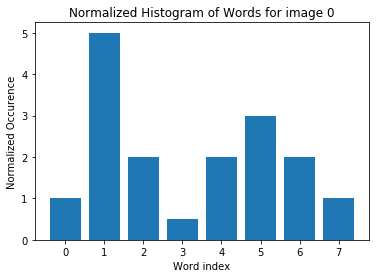

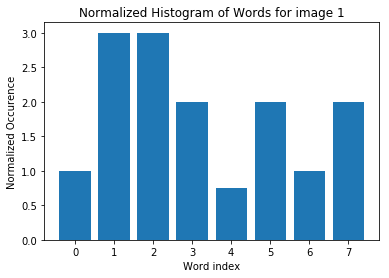

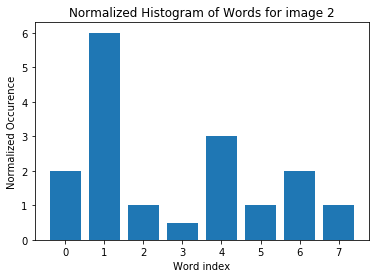

(70,)
[0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Correct 57.0
Wrong 13.0
Accuracy 0.8142857142857143
Bag of words w/ Cell Size 4
Bag of words Shape (75, 20)
Word prediction for image 0 [4 6 0 4 2 0 0 5 6 1 0 0 2 2 3 5 5 3 7 4]
Normalized Word count for image 0 Counter({0: 5, 2: 3, 5: 3, 6: 2, 3: 2, 1: 1, 7: 1, 4: 0.375})
Word prediction for image 1 [1 0 0 0 0 7 1 3 0 3 4 4 4 2 2 6 5 2 1 1]
Normalized Word count for image 1 Counter({0: 5, 4: 3, 2: 3, 3: 2, 7: 1, 6: 1, 5: 1, 1: 0.5})
Word prediction for image 2 [5 6 2 6 1 6 4 1 1 1 4 1 0 3 2 5 1 5 7 4]
Normalized Word count for image 2 Counter({1: 6, 6: 3, 4: 3, 2: 2, 0: 1, 3: 1, 7: 1, 5: 0.375})


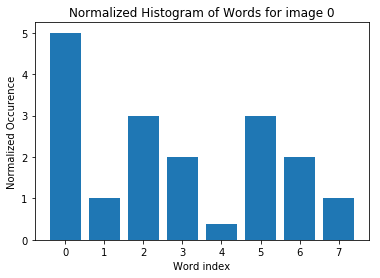

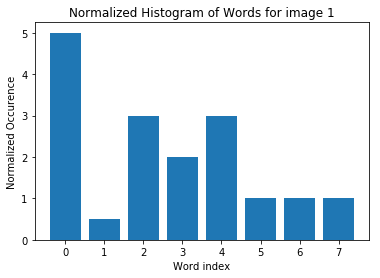

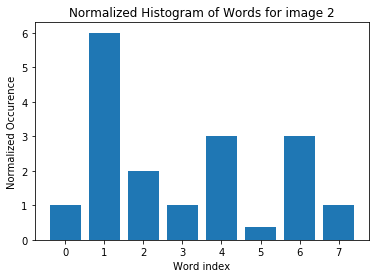

(70,)
[4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]
Correct 57.0
Wrong 13.0
Accuracy 0.8142857142857143
Bag of words w/ Cell Size 5
Bag of words Shape (75, 20)
Word prediction for image 0 [1 6 1 1 5 2 2 4 6 4 5 5 3 3 0 1 2 0 1 7]
Normalized Word count for image 0 Counter({5: 3, 2: 3, 6: 2, 4: 2, 3: 2, 0: 2, 7: 1, 1: 0.625})
Word prediction for image 1 [4 5 1 5 1 1 0 6 2 6 4 4 2 3 3 7 0 1 0 0]
Normalized Word count for image 1 Counter({1: 4, 0: 4, 5: 2, 6: 2, 2: 2, 3: 2, 7: 1, 4: 0.375})
Word prediction for image 2 [4 1 5 1 2 1 6 2 2 2 3 2 3 4 0 4 0 4 7 6]
Normalized Word count for image 2 Counter({2: 5, 1: 3, 6: 2, 3: 2, 0: 2, 5: 1, 7: 1, 4: 0.5})


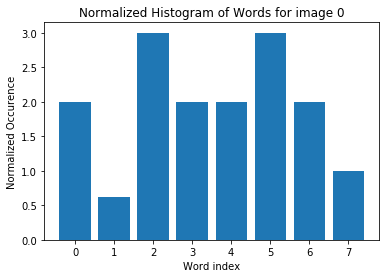

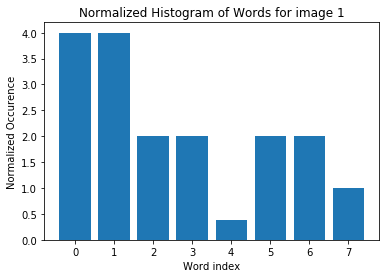

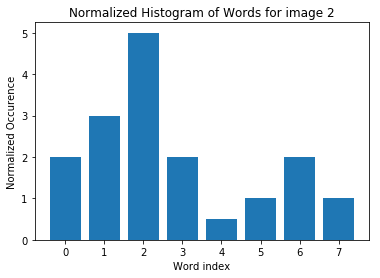

(70,)
[1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Correct 55.0
Wrong 15.0
Accuracy 0.7857142857142857


In [241]:
import collections

NUMBER_OF_WORDS = 8
NUMBER_OF_KEYPOINTS = 20

def makeModel(patches, n_words, cov_type='spherical'):
    gmm_ = mixture.GaussianMixture(covariance_type=cov_type, n_components=n_words)
    gmm_.fit(patches)
    #print(np.shape(patches))
    #print('Weight of each cluster', gmm_test.weights_)
    
    # Assign each feature to a group
    predictions = gmm_.predict(patches)
    
    # Get the count of each word
    counts = collections.Counter(predictions)
    
    # Normalize 
    for word in counts:
        counts[word] /= NUMBER_OF_WORDS
        return predictions, counts
    
def closestDistance(bag_of_words_test, bag_of_words_train):
    min_dist = 1e6
    closest_matching = []
    for i in range(len(bag_of_words_test)):
        indx = i
        for j in range(len(bag_of_words_train)):
            temp_dist = np.linalg.norm(bag_of_words_test[i] - bag_of_words_train[j])
            if(temp_dist < min_dist):
                min_dist = temp_dist
                indx = j
        closest_matching.append(Y_train[indx])

    print(np.shape(closest_matching))
    print(closest_matching)

    accuracy = np.zeros(2)
    for i in range(len(closest_matching)):
        if(Y_test[i] == closest_matching[i]):
            accuracy[0] += 1
        else:
            accuracy[1] += 1

    print('Correct', accuracy[0])
    print('Wrong', accuracy[1])
    print('Accuracy', accuracy[0]/(accuracy[0]+accuracy[1]))
    
    conf = confusion_matrix(Y_test, closest_matching)
    
    return accuracy, conf

def BagOfWords(h_train, h_test):
    # Make a model to predict each group of features for each train image
    bag_of_words_train = []
    counts_train = []
    for i in range(len(h_train)):
        words, count = makeModel(h_train[i], n_words=NUMBER_OF_WORDS)
        bag_of_words_train.append(words)
        counts_train.append(count)

    print('Bag of words Shape', np.shape(bag_of_words))

    for i in range(3):
        print('Word prediction for image '+str(i), bag_of_words_train[i])
        print('Normalized Word count for image '+str(i), counts_train[i])

    # Display the histograms for 3 training images
    for i in range(3):
        n_words = NUMBER_OF_WORDS
        kp = NUMBER_OF_KEYPOINTS
        plt.xticks(np.arange(kp))
        plt.xlabel('Word index')
        plt.ylabel('Normalized Occurence')
        plt.title('Normalized Histogram of Words for image '+str(i))
        plt.bar(*zip(*counts_train[i].items()))
        plt.show()

    # Make a model to predict each group of features for each test image
    bag_of_words_test = []
    counts_test = []
    for img in h_test:
        words, count = makeModel(h_test[i], n_words=NUMBER_OF_WORDS)
        bag_of_words_test.append(words)
        counts_test.append(count)

    # Find closest matching
    accur = closestDistance(bag_of_words_test, bag_of_words_train)
    
    return accur

print('Bag of words w/ Cell Size 3')
acc3, conf3 = BagOfWords(h_3_train, h_3_test)
print('Bag of words w/ Cell Size 4')
acc4, conf4 = BagOfWords(h_4_train, h_4_test)
print('Bag of words w/ Cell Size 5')
acc5, conf5 = BagOfWords(h_5_train, h_5_test)

accuracies = []
accuracies.append(acc3)
accuracies.append(acc4)
accuracies.append(acc5)

confusions = []
confusions.append(conf3)
confusions.append(conf4)
confusions.append(conf5)

Accuracy of Bag of words w/ Cell Size3 81.42857142857143%


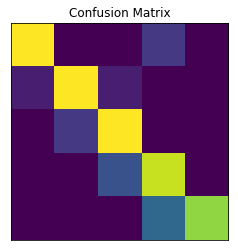

Accuracy of Bag of words w/ Cell Size4 81.42857142857143%


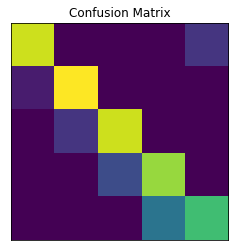

Accuracy of Bag of words w/ Cell Size5 78.57142857142857%


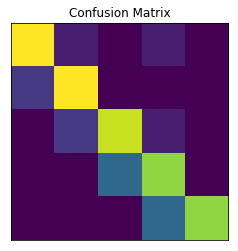

In [242]:
cell_size = [3, 4, 5]
for i in range(len(accuracies)):
    acc = accuracies[i][0] / (accuracies[i][0]+accuracies[i][1])
    print('Accuracy of Bag of words w/ Cell Size' +str(cell_size[i])+' ' +str(acc*100) +'%' )
    plt.figure()
    plt.imshow(confusions[i])
    plt.title("Confusion Matrix"), plt.xticks([]), plt.yticks([])
    plt.show()